<blockquote><h2><b>Abstract</b></h2></blockquote>

Continuous stirred tank reactors (CSTRs) are investigated in aorta arch to match results from the CFD simulations to understand the difference in healty and aneurysm aorta. Assumed the volume of the system is fixed throughout the study and changing the number of tanks (each tank has same volume). Developed the ODE solver by using Euler, RK2 and RK4 methods and evaluated the concentration over time in each tank. Next, calculated the overall flow rate of the system. Furthermore, tested the ODE solver by varying the injection protocols in the first tank and then compared our CSTR model results with the CFD simulation. This model is about checking whether an aorta is healthy or not. The concentration can be compared with those of healthy cases to determine whether an aorta has aneurysm or not. At last, we optimized the CSTR model. With the overall study, we noticed a slight increase in volume in aneurysm aorta case as compared to the healty aorta.

<blockquote><h2><b>Introduction</b></h2></blockquote>
 An ordinary differential equation is a relationship between quantities and their rates of change in time, space or whatever other independent variable we  care to introduce. Ordinary differential equations systems (ODEs) have been widely used for modeling dynamical systems. These model state spaces used in these fields is constantly evolving over time, we call it continuous dynamical system [1]. Models based on ODEs have applications in many science fields such as economics, physics, engineering, and systems biology.

 A continuous stirred tank reactor (CSTR) is a reactor with an impeller for effective mixing. Since it only depends on the system volume and rate of dilution, it is frequently used in a variety of scientific domains as a first approximation for values like residence period in a lake or ocean or for an approximation of a drug's or toxins' residence in the human body [2]. With the CSTR model, aortic arch studies are also possible. The top portion of the major artery carrying blood away from the heart is known as the aortic arch. The common disease to aorta arch is Aneurysm which develops when a portion of the aorta arch enlarges.

### Libraries

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Iniating Continuous Stirred Tank Reactor Class

In [2]:
class CSTR:
    def __init__(self, tanks, Tf, dt, tau, c_ini, flowrate = 5, T_ini = 0, h =0.02, M_inj = 83.333):
        """
        An ordinary differential equation solver to model the concentration of
        specific particles in the Aorta of heart with the mixing tank model and 
        then use the model to identify any unhealthy characteristics of the Aorta.
        The solver uses the same units as stated below:
        Input arguments:
        --------------------------------------------------------------
        tanks: Number of tanks the model uses in the solver to eqaute to Aorta 
        Tf: Final time of the simulation (s)
        dt: Time step for the model (s)
        tau: Total Volume / flow rate (1/s)
        c_ini: Initial concentration of observed particles in each tank (g/cm^3)
        flowrate: The flowrate in tanks (L/min)
        T_ini: Initial starting time of simulation set at 0 (s)
        h: Time step of the given data (s) (0.02 As observed in data)
        M_inj: Total mass of tracer injected (g) (83.33 g as stated in project file)
        -------------------------------------------------------------
        """
        self.n = tanks
        self.T_ini = T_ini 
        self.Tf = Tf
        self.dt = dt
        self.h = h
        self.M_inj = M_inj
        self.tau = tau
        self.q = flowrate *1000/60 # To convert from L/min to cm^3/s
        self.V_total = self.tau * self.q # Total volume of all tanks (cm^3)
        self.V = self.V_total/self.n #Volume of 1 tank (cm^3)
        self.time = np.arange(self.T_ini, self.Tf+self.dt, self.dt)
        self.Cin = np.zeros(len(self.time))
        self.c_ini = c_ini


    def rhs(self, C, t, protocol):
        '''
        Right hand side of the ordinary differential equation
        It loops for the available number of tanks for each given time step.
        '''
        rhs = []
        tank = 0
        c_in = self.c_inj(protocol)[self.count] #changes C_in as per injection protocol and extracts the value at given time step
        while tank < self.n:
            if tank == 0:
                rhs.append(c_in - C[0])
            else:
                rhs.append(C[tank - 1] - C[tank])
            tank+= 1

        return np.array(rhs)*self.n/self.tau


    def rhs_extended(self, C, t, protocol, C_a):
        '''
        The rhs for the extended model in exercise 4
        The function loops in the similarly to the simple model, 
        except the aneurysm is added in one of the tanks, which in this case is
        the third last tank
        '''
        rhs = []
        tank = 0
        c_in = self.c_inj(protocol)[self.count]
        #Values of D and Va set with trial and error method
        D = 0.2*self.q 
        V_a = 5*self.V
        while tank < self.n:
            if tank == 0:
                rhs.append(c_in - C[0])
            elif tank == self.n - 3: #Aneurysm added in the third last tank
                C_a = self.rk4_Ca(C_a, t, D, V_a, C[tank])
                sol = (C[tank - 1] - C[tank]) - ((D/self.q)*(C[tank] - C_a)) #function modified to take (n/tau) as common
                rhs.append(sol)
            else:
                rhs.append(C[tank - 1] - C[tank])
            tank+= 1

        return np.array(rhs)*self.n/self.tau

    def rhs_Ca(self, C_a, t, D, Va, C):
        '''
        rhs for the extended model in exercise 4 for the Aneurysm
        '''
        return (D/Va)*(C - C_a)

    def rk4_Ca(self, y, t, D, Va, C):
        '''
        Runge Kutta-4 applied for extended model exercise 4
        '''
        k1=self.dt*self.rhs_Ca(y,t, D, Va, C)
        k2=self.dt*self.rhs_Ca(y+0.5*k1,t+0.5*self.dt, D, Va, C)
        k3=self.dt*self.rhs_Ca(y+0.5*k2,t+0.5*self.dt, D, Va, C)
        k4=self.dt*self.rhs_Ca(y+k3,t+self.dt, D, Va, C)
        return (k1+2*k2+2*k3+k4)/6

    
    def euler_step(self, y, t, protocol):
        '''
        Euler method solver
        '''
        return self.dt*self.rhs(y, t, protocol)

    def rk2_step(self,y,t, protocol):
        '''
        Runge Kutta-2 method solver
        '''
        k1=self.dt*self.rhs(y,t, protocol)
        k2=self.dt*self.rhs(y+0.5*k1,t+self.dt*0.5, protocol)
        return k2

    def rk4_step(self,y,t, protocol):
        '''
        Runge Kutta-4 method solver
        '''
        k1=self.dt*self.rhs(y,t, protocol)
        k2=self.dt*self.rhs(y+0.5*k1,t+0.5*self.dt, protocol)
        k3=self.dt*self.rhs(y+0.5*k2,t+0.5*self.dt, protocol)
        k4=self.dt*self.rhs(y+k3,t+self.dt, protocol)
        return (k1+2*k2+2*k3+k4)/6

    def rk4_step_extended(self,y,t, protocol, C_a):
            '''
            Runge Kutta-4 for extended model in exercise 4
            Delibrately made seperatley from the main solver to ensure main solver works perfectly
            without any complications
            '''
            k1=self.dt*self.rhs_extended(y,t, protocol, C_a)
            k2=self.dt*self.rhs_extended(y+0.5*k1,t+0.5*self.dt, protocol, C_a)
            k3=self.dt*self.rhs_extended(y+0.5*k2,t+0.5*self.dt, protocol, C_a)
            k4=self.dt*self.rhs_extended(y+k3,t+self.dt, protocol, C_a)
            return (k1+2*k2+2*k3+k4)/6

    def step(self, y,t,method, protocol):
        '''
        Depending on the method solver initiated returns the respective right hand side.
        '''
        if method == 'euler':
            return self.dt*self.rhs(y,t, protocol)
        elif method == 'rk2':
            return self.rk2_step(y,t, protocol)
        elif method == 'rk4':
            return self.rk4_step(y,t, protocol)
        else:
            print('unknown method')

    def solver(self, method, protocol):
        '''
        Main ODE solver. Inputs are the solver method i.e Euler, RK2 or RK4
        and the injection protocol required
        '''
        y_old=self.c_ini
        sol=[]
        count = 0 # To count the time step
        for t in self.time:
            self.count = count
            sol.append(y_old)
            y_next=y_old+self.step(y_old,t,method, protocol)
            y_old=y_next
            count += 1
        return self.time ,np.array(sol)[:,-1] #Extracts the concentration in the last tank only

    
    def solver_extended(self, protocol):
        '''
        ODE solver for excercise 4
        Delibrately made seperatley from the main solver to ensure main solver works perfectly
        without any complications
        '''
        y_old=self.c_ini
        sol=[]
        count = 0 
        C_a = 0
        for t in self.time:
            self.count = count
            sol.append(y_old)
            y_next=y_old+self.rk4_step_extended(y_old,t, protocol, C_a)
            y_old=y_next
            count += 1
        return self.time ,np.array(sol)[:,-1]
    

    def analytical(self):
        '''
        Analytical solution for 1, 2 and 3 tanks only
        '''
        sol = []
        for t in self.time:
            if self.n == 1:
                sol.append(np.exp(-t/self.tau))
            if self.n == 2:
                sol.append((2*t/self.tau)*np.exp(-2*t/self.tau))
            if self.n == 3:
                sol.append(((9*t**2)/(2*self.tau**2))*np.exp(-3*t/self.tau))
        return self.time, np.array(sol)


    def c_inj(self, protocol):
        '''
        Returns the specified injection protocol
        '''
        if protocol == 0: # When initial concentration is zero.
            ti = np.array([0,1.,2.,3.])
            Cin = np.array([0,0,0,0])
            return np.interp(self.time,ti, Cin, right= 0)
        if protocol == 1: # For rect_1s.
            ti = np.array([0, 1., 1.,2., 3. ])
            Cin = np.array([1.,1.,0,0,0])
            return np.interp(self.time,ti, Cin, right= 0)
        if protocol == 2: # For rect_3s.
            ti = np.array([0, 2., 3., 3., 4])
            Cin = np.array([1., 1., 1., 0, 0])
            return np.interp(self.time,ti, Cin, right= 0)   
        if protocol == 3: # For ramp_1s.
            ti = np.array([0, 1., 1.,2., 3. ])
            Cin = np.array([0,1.,0,0,0])
            return np.interp(self.time,ti, Cin, right= 0)
        if protocol == 4: # For biphasic.
            ti = np.array([0, 1., 1.,2., 2., 3.,3.,4. ])
            Cin = np.array([0.7,0.7,0,0,1, 1, 0, 0])
            return np.interp(self.time,ti, Cin, right= 0)


    def Healty_Data(self, protocol):
        '''
        Returns the data set for a healthy Aorta with specified injection protocol
        '''
        if protocol==1: # For rect_1s.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Healthy_rect_1s.csv'
            dt_rec1s = pd.read_csv(url)
            return dt_rec1s

        if protocol==2: # For rect_3s.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Healthy_rect_3s.csv'
            dt_rec3s = pd.read_csv(url)
            return dt_rec3s
        
        if protocol==3: # For ramp_1s.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Healthy_ramp_1s.csv'
            dt_ramp1s = pd.read_csv(url)
            return dt_ramp1s

        if protocol==4: # For biphasic.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Healthy_biphasic.csv'
            dt_biphasic = pd.read_csv(url)
            return dt_biphasic
        
    
    def Aneurysm_Data(self, protocol):
        '''
        Returns the data set for Aorta with Aneurysm with specified injection protocol
        '''
        if protocol==1: # For rect_1s.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Aneurysm_rect_1s.csv'
            dt_a_dt_rec1s = pd.read_csv(url)
            return dt_a_dt_rec1s

        if protocol==2:# For rect_3s.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Aneurysm_rect_3s.csv'
            dt_a_rec3s = pd.read_csv(url)
            return dt_a_rec3s

        if protocol==3: # For ramp_1s.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Aneurysm_ramp_1s.csv'
            dt_a_ramp1s = pd.read_csv(url)
            return dt_a_ramp1s
        
        if protocol==4: # For biphasic.
            url = 'https://raw.githubusercontent.com/ahiorth/CompEngineering/master/projects/H22/project3/data/Aneurysm_biphasic.csv'
            dt_a_biphasic = pd.read_csv(url)
            return dt_a_biphasic
            
  
    def flowrate_q(self):
        '''
        Returns the calculated flowrate with given mass of tracer
        '''
        dt_rec1s = self.Healty_Data(1)
        # Uses numerical integration method (Trapezoidal method) to integrate C_out
        f_a = dt_rec1s['Concentration'].iloc[0] #First value
        f_b = dt_rec1s['Concentration'].iloc[-1] #Last Value
        f_all = np.sum(dt_rec1s['Concentration'].iloc[1:-2]) # Extract all values in betwwen
        c_out = self.h*((f_a+f_b)/2 + (f_all))
        return round((self.M_inj/c_out)*60/1000)   # to convert from cm^3/s to L/min

## **Exercise 1:** Write your own ODE solver
## Part 1
Euler, RK2 and RK4 solvers initiated in the class above

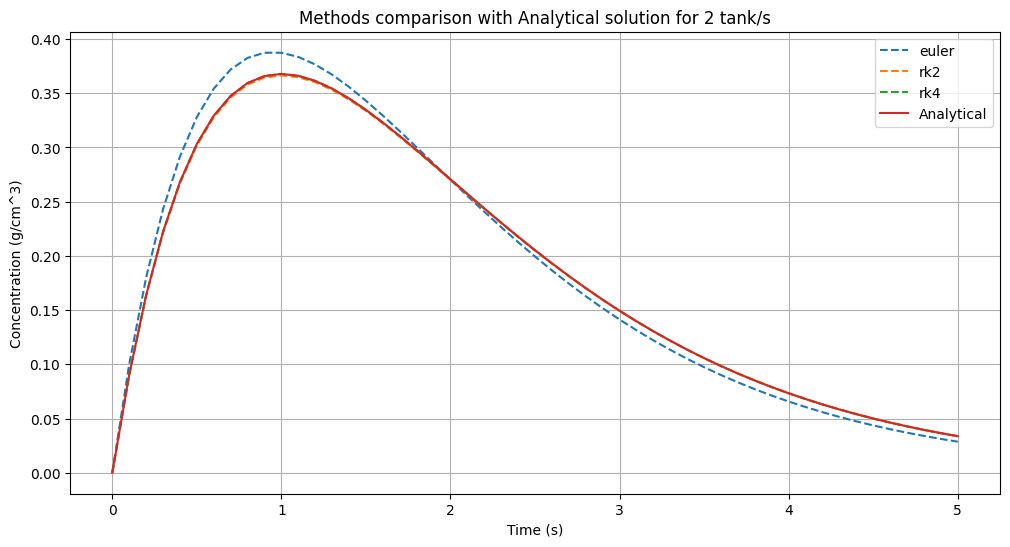

In [3]:
n = 2
Cini = np.zeros(n)
Cini[0] = 1 #Initial concentration in tank 1
tau  = 2 
total_time = 5
time_step = 0.1
OD = CSTR(n, total_time, time_step, tau, c_ini=Cini)
t1, s1 = OD.solver('euler', 0)
t2, s2 = OD.solver('rk2', 0)
t3, s3 = OD.solver('rk4', 0)
t, s = OD.analytical()
plt.figure(figsize= (12, 6))
plt.plot(t1, s1, '--', label = 'euler')
plt.plot(t2, s2, '--', label = 'rk2')
plt.plot(t3, s3, '--', label = 'rk4')
plt.plot(t, s, label = 'Analytical')
plt.title('Methods comparison with Analytical solution for {} tank/s'.format(n))
plt.xlabel('Time (s)')
plt.ylabel('Concentration (g/cm^3)')
plt.legend()
plt.grid()

### Discussion:  
The solution is not much accurate with a single tank but gets better for increasing the number of tanks for each method. Reducing the time step aslo effects the accuracy of each method.

## Part 2

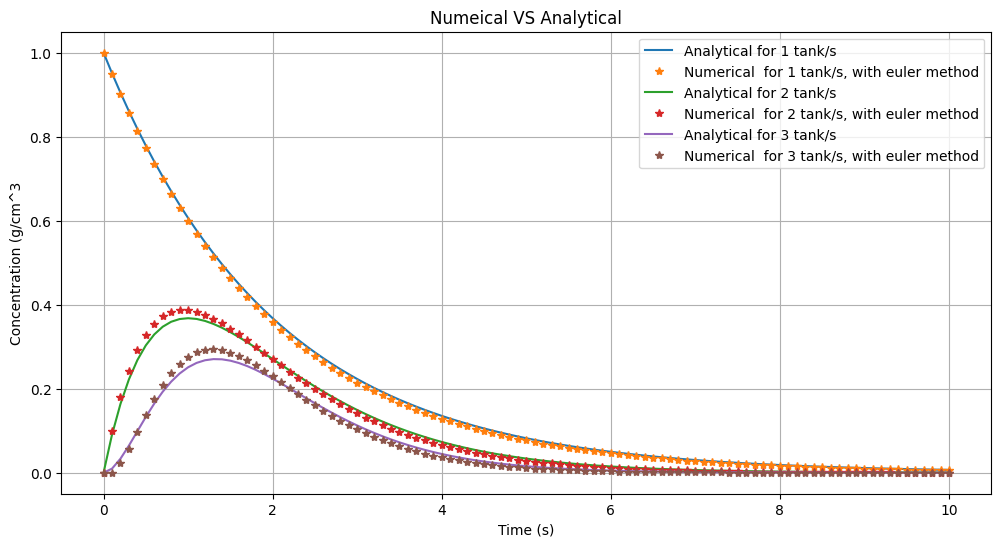

In [4]:
tau  = 2 
total_time = 10
time_step = 0.1
tanks = [1,2,3]
plt.figure(figsize=(12,6))
method = 'euler'
for i in tanks:
    Cini = np.zeros(i)
    Cini[0] = 1
    OD = CSTR(i, total_time, time_step, tau, c_ini=Cini)
    t, s = OD.analytical()
    t1, s1 = OD.solver(method,0) # 0 denotes protocol.
   
    plt.plot(t,s,'-', label = 'Analytical for {} tank/s'.format(i))
    plt.plot(t1,s1,'*', label = 'Numerical  for {} tank/s, with {} method'.format(i, method))
    plt.title('Numeical VS Analytical')
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration (g/cm^3')
    plt.legend()
    plt.grid()

### Discussion:
Implemented the analytical and CSTR model for 1, 2 and 3 tanks. The method can be changed from euler to rk2 or rk4 to see the comparison of the respective method with the analytical solution

## Part 3

Text(0.5, 1.0, 'Error for each solver method w.r.t time step.')

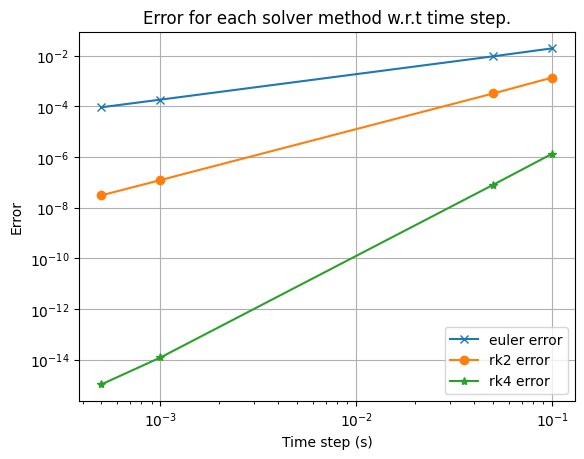

In [5]:
DT = [0.1, 0.05, 0.001, 0.0005] #Time step array
error1 = []
error2 = []
error3 = []
total_time = 1
n = 2 # Getting error for a 2 tank model
Cini = np.zeros(n)
Cini[0] = 1 #Initial concentration in tank 1
for dt in DT:
    OD = CSTR(n, total_time, dt, tau, c_ini=Cini)
    t1, s1 = OD.solver('euler', 0)
    t2, s2 = OD.solver('rk2', 0)
    t3, s3 = OD.solver('rk4', 0)
    t, s = OD.analytical()
    
    err1 = np.abs(s1[np.where(t1 == 1)][0] - s[np.where(t == 1)][0])
    err2 = np.abs(s2[np.where(t2 == 1)][0] - s[np.where(t == 1)][0])
    err3 = np.abs(s3[np.where(t3 == 1)][0] - s[np.where(t == 1)][0])

    error1.append(err1)
    error2.append(err2)
    error3.append(err3)

plt.plot(DT, error1, 'x-', label = 'euler error')
plt.plot(DT, error2, 'o-', label = 'rk2 error')
plt.plot(DT, error3, '*-', label = 'rk4 error')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Time step (s)')
plt.ylabel('Error')
plt.title('Error for each solver method w.r.t time step.')

### Discussion:
In the first graph, we can see that the rk4 technique is quite close to the true solution (analytical) as compared to the rk2 and euler methods.  In this graph, by comparing the errors of the three different approaches, we can see that the rk4 method has the lowest error. The error for each method scales approximately as expected theoretically; rk4 scales with power of 4, rk2 scales with power of 2 and euler with power of 1.

## **Exercise 2:** Fit CSTR model to CFD model: Healthy aorta
## Part 1

In [6]:
q = OD.flowrate_q() # (L/min)
print('Flow rate with 83.333 grams of tracer injected with Healthy rect_1s protocol is: {} L/min'.format(q))

Flow rate with 83.333 grams of tracer injected with Healthy rect_1s protocol is: 5 L/min


## Part 2

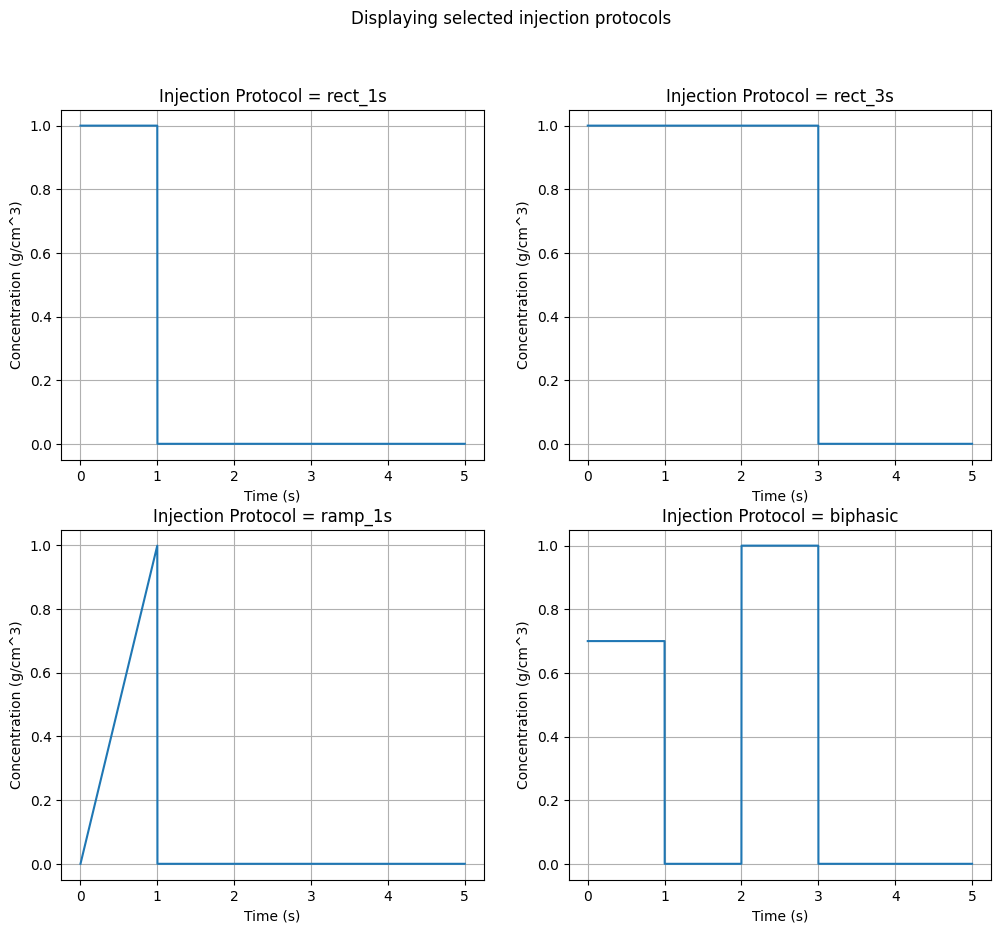

In [7]:
total_time = 5
time_step = 0.001
tau = 2
OD = CSTR(n, total_time, time_step, tau, c_ini=Cini)
fig, axs = plt.subplots(2,2, figsize = (12,10))
fig.suptitle('Displaying selected injection protocols')
i = 0
protocol = ['rect_1s', 'rect_3s', 'ramp_1s', 'biphasic']

while i < 4:
    cinj = OD.c_inj(i+1)
    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(OD.time, cinj, '-')
    axs[l, m].set_title('Injection Protocol = {}'.format(protocol[i]))
    axs[l, m].set(xlabel="Time (s)",ylabel="Concentration (g/cm^3)")
    axs[l, m].grid()
    i+= 1

## Part 3 & 4:
### First doing manual curve fitting

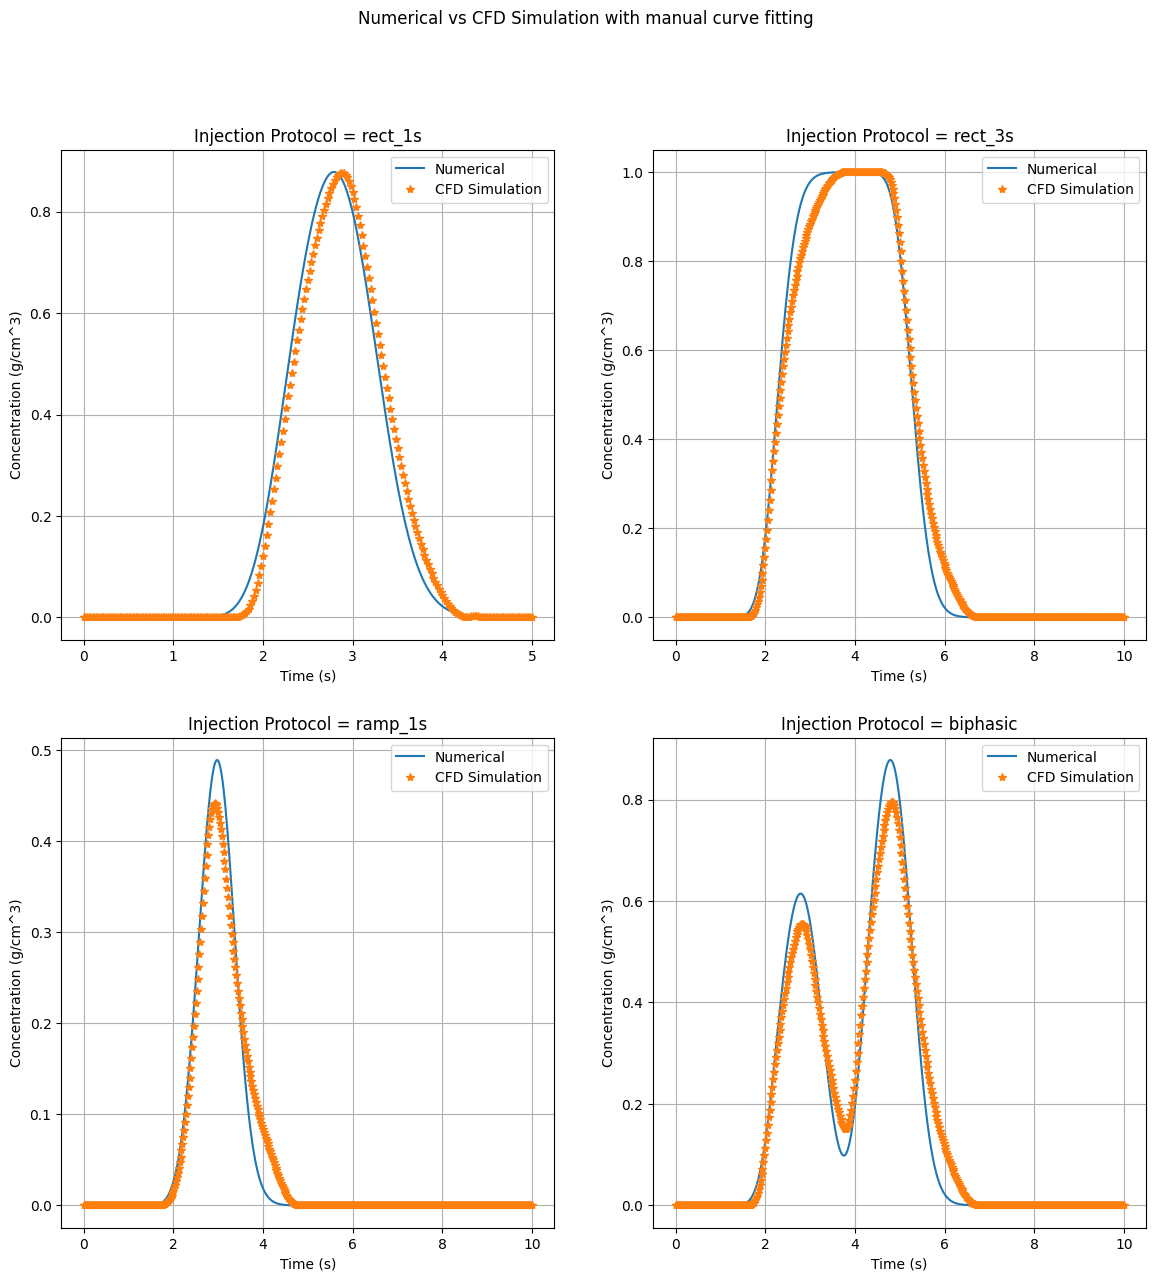

In [8]:
protocol = ['rect_1s', 'rect_3s', 'ramp_1s', 'biphasic']
total_time = [5, 10, 10, 10]
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Numerical vs CFD Simulation with manual curve fitting')
n = 50
Cini = np.zeros(n)
time_step = 0.02
tau = 2.3
# Making subplots for different injection protocols
i = 0
while i < len(protocol):

    OD = CSTR(n, total_time[i], time_step, tau, Cini)
    t, s = OD.solver('rk4', i+1) # Using rk4 method for better accuracy
    CFD = OD.Healty_Data(i+1)

    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(t, s, '-', label = 'Numerical')
    axs[l, m].plot(CFD['Time'], CFD['Concentration'], '*', label = 'CFD Simulation')
    axs[l, m].set_title('Injection Protocol = {}'.format(protocol[i]))
    axs[l, m].set(xlabel="Time (s)",ylabel="Concentration (g/cm^3)")
    axs[l, m].grid()
    axs[l, m].legend()
    i+= 1

## Disscusion:

Successfully manually matched the CSTR model with CFD simulation of healthy case, rect_1 only and then the simulation for other injection protocols is shown with 50 tanks and tau value 2.3.

### Curve Fitting with Scipy Optimize

In [9]:
h = OD.Healty_Data(1)
x = h['Time'].values
y = h['Concentration'].values
q = OD.flowrate_q()
tanks = [48, 49, 50, 51, 52, 53, 54]
for n in tanks:

    def test_func(q, tau):
    
        Cini = np.zeros(int(n))
        total_time = 5
        time_step = 0.02
        flow_rate = q
        OD = CSTR(n, total_time, time_step, tau, Cini, flowrate= flow_rate)
        _, s = OD.solver('rk4', 1)
        return s

    p, cov = sp.optimize.curve_fit(test_func, x, y)

    print('Numer of tanks: ',n, ',tau: ', p,',variance: ', cov)

Numer of tanks:  48 ,tau:  [2.36571218] ,variance:  [[1.64612428e-06]]
Numer of tanks:  49 ,tau:  [2.36549968] ,variance:  [[1.60311614e-06]]
Numer of tanks:  50 ,tau:  [2.36529219] ,variance:  [[1.63588228e-06]]
Numer of tanks:  51 ,tau:  [2.36508939] ,variance:  [[1.73509405e-06]]
Numer of tanks:  52 ,tau:  [2.3648911] ,variance:  [[1.89255047e-06]]
Numer of tanks:  53 ,tau:  [2.36469696] ,variance:  [[2.10101511e-06]]
Numer of tanks:  54 ,tau:  [2.36450678] ,variance:  [[2.35410947e-06]]


After conducting manual curve fitting, scipy optimize was run for tanks from 48 to 54 to see which number of tanks gives the lowest variance. From the function 49 tanks and tau of 2.365 gives the best fit

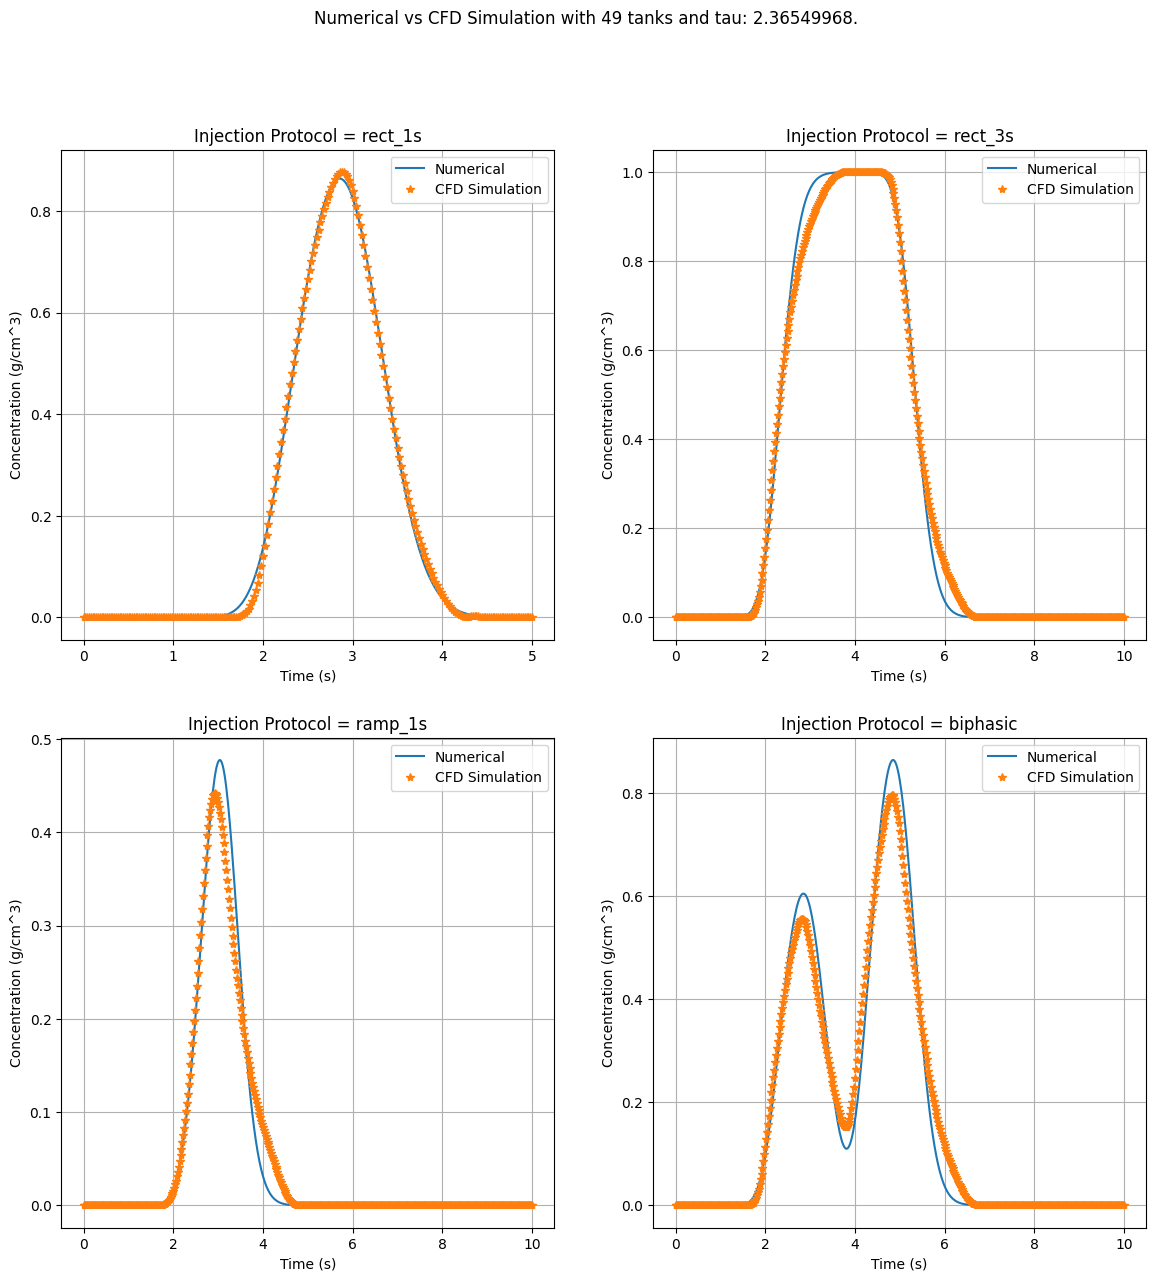

In [10]:
protocol = ['rect_1s', 'rect_3s', 'ramp_1s', 'biphasic']
total_time = [5, 10, 10, 10]
fig, axs = plt.subplots(2,2, figsize = (14,14))
n = 49
Cini = np.zeros(n)
time_step = 0.02
tau = 2.36549968
fig.suptitle('Numerical vs CFD Simulation with {} tanks and tau: {}.'.format(n, tau))
# Making subplots for different injection protocols
i = 0
while i < len(protocol):

    OD = CSTR(n, total_time[i], time_step, tau, Cini)
    t, s = OD.solver('rk4', i+1) # Using rk4 method for better accuracy
    CFD = OD.Healty_Data(i+1)

    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(t, s, '-', label = 'Numerical')
    axs[l, m].plot(CFD['Time'], CFD['Concentration'], '*', label = 'CFD Simulation')
    axs[l, m].set_title('Injection Protocol = {}'.format(protocol[i]))
    axs[l, m].set(xlabel="Time (s)",ylabel="Concentration (g/cm^3)")
    axs[l, m].grid()
    axs[l, m].legend()
    i+= 1

In [11]:
V_total = tau * OD.q
print('Total volume evaluated for the model is :', round(V_total, 2), 'cm^3')

Total volume evaluated for the model is : 197.12 cm^3


## Discussion

The curve fitting is best for the rect_1s case, however for the other injection protocols, the fitting is not that accurate but still it follows the same curve shape with little deviation.
If we reduce time step to do the curve fiiting manually, the model fits better for other protocols as well, however, time step cannot be reduced for scipy optimize therefore 0.02 time step is chosen for both methods.

## **Exercise 3:** Fit CSTR model to CFD model: Aneurysm aorta
## Part 1 & 2
Similar procedure was followed for Aneurysm case; first manual curve fitting was done and then scipy optimize was run to find the best fit values of number of tanks and tau.

In [12]:
h = OD.Aneurysm_Data(1)
x = h['Time'].values
y = h['Concentration'].values
q = OD.flowrate_q()
tanks = [20, 21, 22, 23, 24, 25]
for n in tanks:

    def test_func(q, tau):
    
        Cini = np.zeros(int(n))
        total_time = 5
        time_step = 0.02
        flow_rate = q
        OD = CSTR(n, total_time, time_step, tau, Cini, flowrate= flow_rate)
        _, s = OD.solver('rk4', 1)
        return s

    p, cov = sp.optimize.curve_fit(test_func, x, y)

    print('Numer of tanks: ',n, ',tau: ', p,',variance: ', cov)

Numer of tanks:  20 ,tau:  [2.45690557] ,variance:  [[5.23753823e-05]]
Numer of tanks:  21 ,tau:  [2.45476903] ,variance:  [[4.86626685e-05]]
Numer of tanks:  22 ,tau:  [2.45281711] ,variance:  [[4.66499982e-05]]
Numer of tanks:  23 ,tau:  [2.45102166] ,variance:  [[4.59107209e-05]]
Numer of tanks:  24 ,tau:  [2.44936068] ,variance:  [[4.61258973e-05]]
Numer of tanks:  25 ,tau:  [2.44781477] ,variance:  [[4.70535018e-05]]


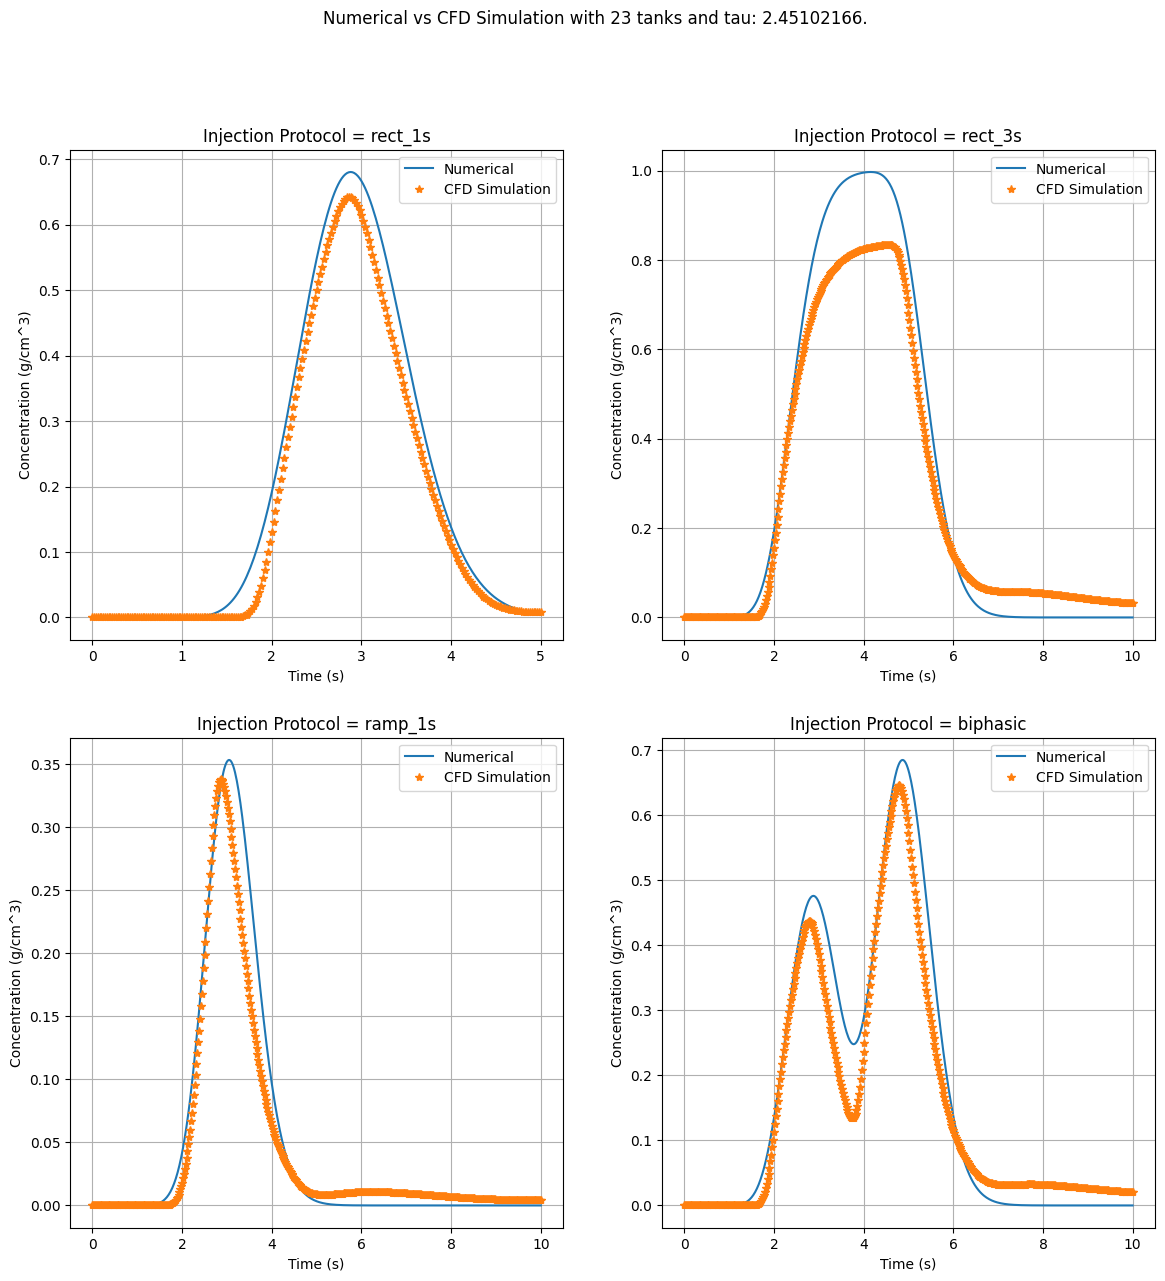

In [13]:
protocol = ['rect_1s', 'rect_3s', 'ramp_1s', 'biphasic']
total_time = [5, 10, 10, 10]
fig, axs = plt.subplots(2,2, figsize = (14,14))
n = 23
Cini = np.zeros(n)
time_step = 0.02
tau = 2.45102166
fig.suptitle('Numerical vs CFD Simulation with {} tanks and tau: {}.'.format(n, tau))
# Making subplots for different injection protocols
i = 0
while i < len(protocol):

    OD = CSTR(n, total_time[i], time_step, tau, Cini)
    t, s = OD.solver('rk4', i+1) # Using rk4 method for better accuracy
    CFD = OD.Aneurysm_Data(i+1)

    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(t, s, '-', label = 'Numerical')
    axs[l, m].plot(CFD['Time'], CFD['Concentration'], '*', label = 'CFD Simulation')
    axs[l, m].set_title('Injection Protocol = {}'.format(protocol[i]))
    axs[l, m].set(xlabel="Time (s)",ylabel="Concentration (g/cm^3)")
    axs[l, m].grid()
    axs[l, m].legend()
    i+= 1

In [14]:
V_total = tau * OD.q
print('Total volume evaluated for the model is :', round(V_total, 2), 'cm^3')

Total volume evaluated for the model is : 204.25 cm^3


## Part 3

Matched the CSTR model with CFD simulation for aneurysm case with 23 tanks and a volume of 204 cm^3. We observed an increase in volume in this case due to the aneurysm in the aorta, which is understandable. It is observed that the number of compartments decreased in aneurysm case because the maximum concentration reached reduces and the spread of concentration with respect to time increases. Thus less number of tanks simulate the same concentration profile as the CFD model.

## Part 4

As discussed earlier, the CSTR model is quite accurate to analyze for a normal (Healthy) aorta but for aneurysm case, it does not model the concentration profile acccurately. Moreover since the curve fit is done using rect_1s data, the deviation of model from data for other injection protocols increases even further.

One important point to infer is that the change in number of tanks from healthy to unhealthy aorta is an important parameter to highlight if a person has aneurysm or not.

## **Exercise 4:** Extended model
## Part 1

Text(0.5, 1.0, 'Aneurysm with extended model')

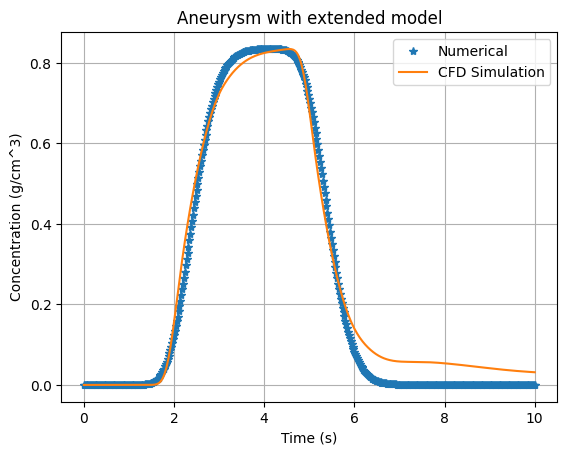

In [15]:
n = 33
tau = 2.45
Cini = np.zeros(n)
total_time = 10
time_step = 0.02
OD = CSTR(n, total_time, time_step, tau, Cini)
t, s = OD.solver_extended(2)

h_rec1s = OD.Aneurysm_Data(2)
#print(t, s)
plt.plot(t, s, '*', label = 'Numerical')
plt.plot(h_rec1s['Time'], h_rec1s['Concentration'], label = 'CFD Simulation')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (g/cm^3)')
plt.legend()
plt.grid()
plt.title('Aneurysm with extended model')

## Discussion
The extended model is more precsie in modeling the concentration profile for the unhealthy case. However, some observation for the extended model is that the total number of tanks needs to be increased to fit the data better.
In current model the aneurysm is fitted in third last tank of the model; if aneurysm is fitted in more than one tanks it may show even better fit to the data.

## Compsrison between Simple and Extended model

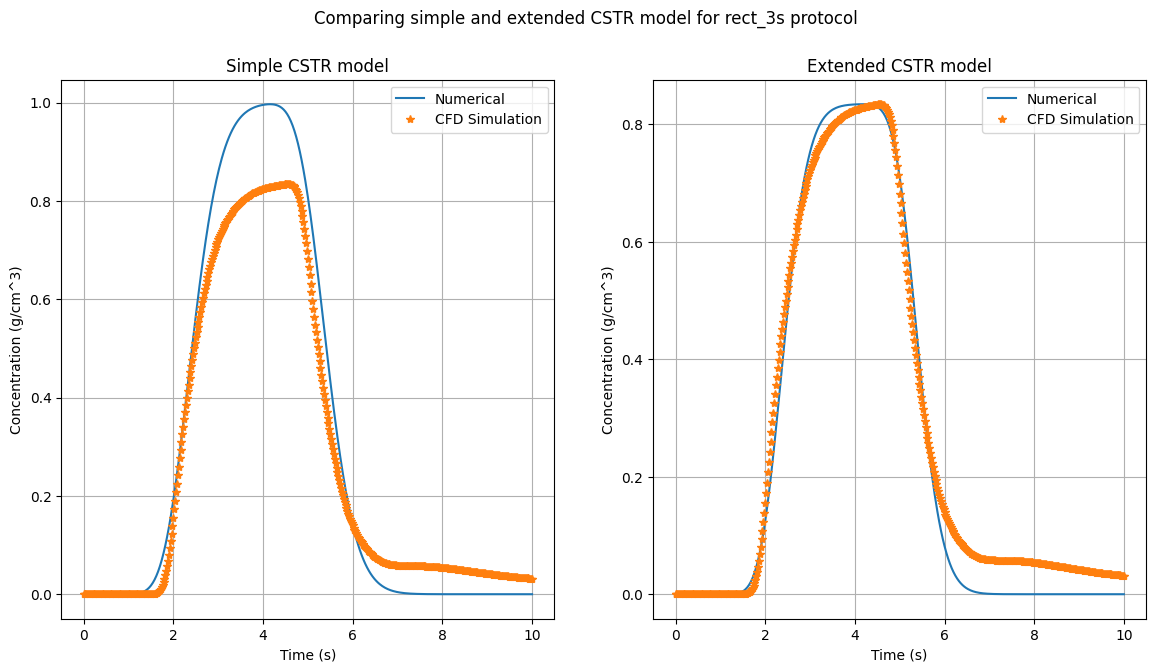

In [16]:
total_time = 10
#t, s = OD.solver('rk4', 2) # Using rk4 method for better accuracy
#t1, s1 = OD.solver_extended(2)
CFD = OD.Aneurysm_Data(2)
fig, axs = plt.subplots(1, 2, figsize = (14,7))
fig.suptitle('Comparing simple and extended CSTR model for rect_3s protocol')
i = 0
model = ['Simple', 'Extended']
while i < 2:
    if i == 0:
        n=23
        Cini = np.zeros(n)
        OD = CSTR(n, total_time, time_step, tau, Cini)
        t, s = OD.solver('rk4', 2)
    if i==1:
        n= 33
        Cini = np.zeros(n)
        OD = CSTR(n, total_time, time_step, tau, Cini)
        t, s = OD.solver_extended(2)
    axs[i].plot(t, s, '-', label = 'Numerical')
    axs[i].plot(CFD['Time'], CFD['Concentration'], '*', label = 'CFD Simulation')
    axs[i].set_title('{} CSTR model'.format(model[i]))
    axs[i].set(xlabel="Time (s)",ylabel="Concentration (g/cm^3)")
    axs[i].grid()
    axs[i].legend()
    i+= 1

<blockquote><h2><b>Conclusion</b></h2></blockquote>

After developing an ODE solver using the Euler, RK2, and RK4 methods and comparing it to the CFD simulation, it was determined that the RK4 approach is more accurate than the RK2 and Euler method, and their error scales as expected when time step is decreased.

Then, for both healthy and aneurysm aorta, the CFD simulation was compared with the CSTR model. The ODE solver does not produce reasonable results with few number of tanks, therefore parameters such as the number of tanks, and total volume are varied to bring the CSTR model closer to the CFD simultation. Another important conclusion is that by decreasing the time step more accuracy can be achieved, therefore if the data with smaller time step can be obtained model parameters can be adjusted to fit better for other injection protocols as well.

Final conclusion is to realize the importance of computation modeling of real life scenarios, and how simple models can be used to help in some very important problems, which in this case was detecting the abnormality in the aorta of a person.

<blockquote><h2><b>References</b></h2></blockquote>

<pre>
[1] Gloria I. Valderrama-Bahamóndez and Holger Fröhlich MCMC, in Techniques for Parameter Estimation of ODE Based Models in Systems Biology,01 Nov 2019
    
[2] Continuous Stirred Tank Reactor (CSTR): (Follows Middleman p. 301-306 and 340-348)